<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 4-1: Word Embeddings <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

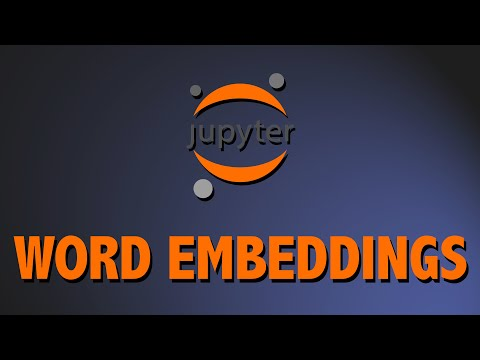

In [41]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('JrVHMfgXoAE', width=640, height=360)

# Word Embeddings

Today, we'll have a look at word embeddings using Gensim's `word2vec` method. 

The goal of word vector embedding models is to learn dense, numerical vector representations for each term in a corpus vocabulary. If successful, the vectors for each term encode information about the meaning or concept the term represents, as well as the relationship between it and other terms in the vocabulary. Word vector models are  fully unsupervised: they learn all of these meanings and relationships without any advance knowledge. Read [this post](https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-6-word-embeddings-f92bba876d60) I wrote for an introduction on Word Embeddings, or see [this video](
https://www.youtube.com/watch?v=5PL0TmQhItY).

After working through today's notebook, you'll be able to:

1. Use Gensim's word2vec method to create word vectors for a corpus;
2. Use these word vectors to reflect on implicit binaries and normativities in your data;
3. Visualize topic models using K-means clustering.

*NOTE: this notebook assumes you have Gensim v4 or higher.*


In [44]:
# Check which version of Gensim you have
import gensim
print(gensim.__version__)

4.2.0


In [15]:
# Uncomment the lines below if you need to install or upgrade

# !pip install gensim
# !pip install --upgrade gensim

## Using comments data

As we will be considering the language biases in the next notebook, we will use the **comments** of our subreddit this time. The thinking behind this is that this data will be derived from more people, and include more evaluative statements (after all, comments on r/amitheasshole generally evaluate the original posts).

*If you are still working with your own submissions data, don't forget to alter the next few cells where we're subsetting the 'body' column--change those to 'selftext'.*

In [2]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [3]:
import pandas as pd 

df = pd.read_csv('aita_com_top.csv')
df.head(3)

,Unnamed: 0,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
0,0,27068149210,t1_cfnodlm,1393275432,swallowedfilth,t3_1ytr72,t3_1ytr72,Seems like you have a genuine reason to be ups...,33.0,AmItheAsshole,NaN,210.0
1,1,27068245493,t1_cfnqfw5,1393279437,RoonilaWazlib,t3_1ytxov,t3_1ytxov,There is nothing wrong with your original comm...,47.0,AmItheAsshole,NaN,561.0
2,2,27068297463,t1_cfnrjzr,1393281730,flignir,t3_1yu29c,t3_1yu29c,Yep. You're the asshole. If you want to make...,116.0,AmItheAsshole,NaN,1118.0


We need to preprocess our text again (as we haven't done that yet). We'll save our preprocessed data again in a dedicated 'lemmas' column.

In [47]:
df = df[~df['body'].isin(['[removed]', '[deleted]' ])].dropna(subset=['body'])
df = df[df['body'].str.len()>=15]
len(df)

255075

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

def clean(token):
    """
    helper function to eliminate tokens
    that are pure punctuation, whitespace, or digits
    """
    return token.is_punct or token.is_space or token.is_digit

def line_read(df):
    """
    generator function to read in text from df
    and get rid of line breaks in the text
    """    
    for text in df.body:
        yield text.replace('\n', '')

def preprocess(df, allowed_postags=['NOUN', 'ADJ']):
    for parsed in nlp.pipe(line_read(df), batch_size=1000, disable=["tok2vec", "ner"]):
        lemmas = [token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_ 
                    for token in parsed if not clean(token)]
        lemmas_c = [l for l in lemmas if not l in ["'s",  "’s", "’"] and not l in allowed_postags]
        nostops = [term for term in lemmas_c if term not in spacy.lang.en.stop_words.STOP_WORDS]
        yield nostops

In [ ]:
lemmas = [line for line in preprocess(df)]

In [ ]:
# create bigram and trigram models
bigram = Phrases(lemmas, min_count=20, threshold=300)
trigram = Phrases(bigram[lemmas], min_count=20, threshold=100)  
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

def make_bigrams(texts):
    return [bigram_phraser[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

# Form trigrams
trigrams = make_trigrams(lemmas)


In [ ]:
len(trigrams)

Let's save the data to JSON.

In [51]:
import json

#with open('aita_com_top_lemmas.json', 'w') as write:
#    json.dump(trigrams, write)
    
# Opening the same file works as follows:
with open("aita_com_top_lemmas.json") as f:
    trigrams = json.load(f)



## Word2Vec

Let's create our word embeddings model. 

While last week's LDA method was focused on finding topics in a collection of documents (or in our case, submissions), word embeddings modeling focuses on individual words, and learning a vector representation of these words.

The input here is a text corpus split up in sentences – in word embeddings, there is no concept of "documents". The model's output is a set of "vectors" (one for each word) in N dimensions. Think of these vectors as "features", capturing latent meaning.

This model allows us to group the vectors of similar words together in vectorspace. We can then reduce the dimensionality to visualize the results in a way humans can understand (such as in a 2-dimensional space), or to perform linear algebra in order to find out to what extent words are related.

Word2Vec is one example of a word embeddings model. It learns by taking words and their contexts (e.g. sentences) into account, and can then try to predict other words. Given enough data, usage and contexts, word2vec can make accurate guesses about a word’s meaning based on its appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic.

We now instantiate and train our Word2Vec model, using the parameters below.

In [52]:
from gensim.models import Word2Vec
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores you have at your disposal
num_features = 300        # Word vector dimensionality (how many features each word will be given)
min_word_count = 10        # Minimum word count to be taken into account
num_workers = cores       # Number of threads to run in parallel (equal to your amount of cores)
context = 5               # Context window size
downsampling = 1e-2       # Downsample setting for frequent words
seed_n = 1                # Seed for the random number generator (to create reproducible results) 
sg_n = 1                  # Skip-gram = 1, CBOW = 0
epochs = 20

model = Word2Vec(trigrams, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=seed_n, sg=sg_n)

In [53]:
model.train(trigrams, total_examples=model.corpus_count, epochs=10)        

(55430230, 56925570)

That was it! We have a Word Embeddings model now.

In [54]:
model.save('aita_com.emb')

In [19]:
from gensim.models import Word2Vec

model = Word2Vec.load('aita_com.emb')

How many terms are in our vocabulary?

In [55]:
print('{:,} terms in the vocabulary.'.format(len(model.wv)))

14,743 terms in the vocabulary.


### Getting related terms

With the information in our word embeddings model, we can try to find similarities between words that interest us (i.e. words that have a similar vector). Let's create a function that retrieves related terms to some input.

In [56]:
def get_related_terms(token, topn=20):
    """
    look up the topn most similar terms to token and print them as a formatted list
    """

    for word, similarity in model.wv.most_similar(positive=[token], topn=topn):
        print(word, round(similarity, 3))

In [57]:
get_related_terms('asshole')

assholeishness 0.554
ta 0.538
esh.your 0.499
ytais 0.488
nahyou’re 0.488
fuckwad 0.486
ytfa 0.485
here**|**esh****no_hole_here**|**nah****not 0.475
redflag 0.468
ytain 0.467
this:>i 0.461
irredeemable 0.459
ytayeah 0.454
lmaooo 0.454
ntaeveryone 0.45
ja 0.448
party_|**nta****everyone_sucks 0.446
resounding 0.446
info**|**info**#[click 0.446
shp- 0.445


### Word algebra

Word algebra, also known as analogy completion, means doing math with words (like the famous example "king - man + woman = queen"). The core idea is that once words are represented as numerical vectors, you can do math with them. The mathematical procedure works as follows:

1. Provide a set of words or phrases you want to add or subtract.
2. Look up the vectors that represent those terms in the word vector model.
3. Add and subtract those vectors to produce a new, combined vector.
4. Look up the most similar vector(s) to this new, combined vector via cosine similarity.
5. Return the word(s) associated with the similar vector(s).

Let's try it out. We'll create a function that does this for us.

In [58]:
def word_algebra(add=[], subtract=[], topn=10):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = model.wv.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [59]:
word_algebra(add=['men', 'dating'])

woman
man
women
date
okcupid
5’4
fetishization
transman
femme
libidos


In [60]:
word_algebra(add=['women', 'dating'])

woman
libidos
cisgender
transman
fetishization
date
transgendere
femme
cosmo
man


## K-means clustering
One convenience of word embeddings is that we can cluster them using, for instance, K-Means clustering. 

K-Means clustering aims to partition N observations into K clusters in which each observation belongs to the cluster with the nearest mean (called the "cluster centre"), which serves as a prototype of the cluster.

Since our words are all represented as vectors, applying K-Means is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [61]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE

def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    return kmeans_clustering.cluster_centers_, idx;

In [62]:
Z = model.wv.vectors # The syn0 array essentially holds raw word-vectors

In [63]:
centers, clusters = clustering_on_wordvecs(Z, 20);
centroid_map = dict(zip(model.wv.index_to_key, clusters));

Next, we get words in each cluster that are closest to the cluster center. To do this, we initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center. Using the Index 2 word dictionary, we than correspond each word vector back to it’s original word representation and add them to a dataframe for easier printing.

In [64]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    # Use closest points for each cluster center to query closest 20 points to it
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    # Query Word Index  for each position in the above array, and added to a Dictionary
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    # Create DataFrame from dictionary
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

Let’s get the top words and print the first 20 in each cluster:

In [65]:
import numpy as np

top_words = get_top_words(model.wv.index_to_key, 10, centers, Z);

In [66]:
top_words[:30]

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19
1,ntaplease,ytagrow,ytagrow,lmaooo,ytagrow,⡀,ytagrow,intensifie,ytagrow,ytagrow,ntawho,ytagrow,ytagrow,nta.when,ytagrow,burritos,ytagrow,anemia,nta.why,intensifie
2,esh.it,ytalike,lmaooo,ytagrow,slick,⢠,nta--,ntawhen,ntaeveryone,ooof,esh.it,ntaplease,nta.so,ntaplease,think,lentil,ntaare,whataboutism,nta.people,nta.in
3,intensifie,think,ntaplease,shp-,ooof,⠃,ytahave,ytagrow,nta.in,whataboutism,ntaplease,lmaooo,ntaeven,ytagrow,ntaeven,cauliflower,ntaits,nta.so,ntaits,britain
4,ytalike,ntaplease,ntaeveryone,intensifie,ytalike,⣄,yale,eshwhy,whataboutism,ntawhen,😑,ntaeveryone,ntalet,ntawho,nta.so,pesto,ntai'd,radiation,nta.first,portugal
5,ytagrow,know,think,brandnewsentence,daisy,⡟,eshwhy,ntaits,nta.so,nta.so,intensifie,think,ntaplease,time,nta.first,patty,ntaeveryone,ytagrow,ytathey,iran
6,eshwhy,ntaeven,nta.people,rareinsult,ntaeven,⠁,ntaits,shp-,esh.the,ntaeveryone,eshwhy,nta.so,nta.some,intensifie,know,spinach,ntaplease,incision,ytagrow,seattle
7,^^^,ntalet,ntawho,ntaplease,ntaplease,wikitextbot,intensifie,ntaplease,ntaeven,ytano,ytalike,eshwhy,think,ntaeven,mean,yta.as,^^^,constipation,ytahave,houston
8,ntaits,want,ntaeven,^^^,nta.in,⠋,ytaget,ty,think,think,lysol,esh.if,ntawow,nta.so,ntawhen,breadstick,eshwhy,dormant,ntawho,tourism
9,ntawho,nta.so,shp-,ytfa,sandal,⣶,nta.when,ytaget,ytano,ytalike,^^^,ytais,traumatized,nta.first,eshwhy,gobble,esh.if,gardasil,7k,funnily
10,ytaget,intensifie,ytfa,ytalike,😐,index)#[click,js,lmaooo,nta.some,esh.the,ytagrow,ytaeveryone,eshwhy,eshwhy,ntaeveryone,eggplant,ytaeveryone,nta.a,ntalet,iceland


## Plot words with PCA

[Principal component analysis](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) and related dimension-reduction algorithms are an excellent way to visualize multivariate data in reduced dimensional space - such as a 2D scatterplot. 

In [67]:
# Save the word2vec vocab vectors
features = [model.wv[word] for word in model.wv.index_to_key]

In [68]:
from sklearn.decomposition import PCA

# Define parameters of our PCA
# Just look at the first two dimensions - the X and Y axes
pca = PCA(n_components = 2)
pca_out = pca.fit_transform(features)

Let's plot this with the top words (just to keep things slightly uncluttered - visualizing word embeddings is a tricky job!)

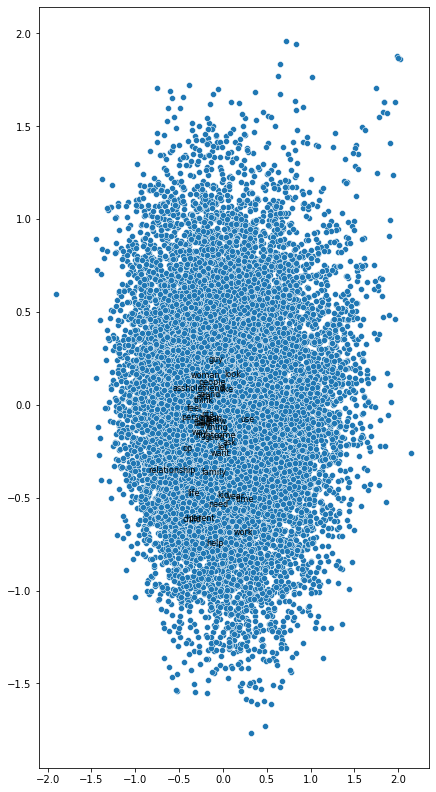

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (7,14))
sns.scatterplot(x=pca_out[:, 0], y=pca_out[:, 1])
words = list(model.wv.index_to_key)
# Annotate only the top words 
for i, word in enumerate(words[0:40]):
    plt.annotate(word, size = 8, xy = (pca_out[i, 0], pca_out[i, 1]))
plt.show()

# Reflection: the hermeneutics of word embeddings

“In vector space, identities and differences change in nature. Similarity and belonging no longer rely on resemblance or a common genesis but on measures of proximity or distance, on flat loci that run as vectors through the space.” (Dourish 2018: 73-4)

As we've seen, word embeddings are essentially a set of vectors. We should reflect on this. What is vectorization? It is reducing linguistic complexity. Or rather, it produces a common space that juxtaposes and mixes complex localized realities. Anything can be turned into a vector operation, but what do we lose when doing so? 